问题：根据探索性分析的结果，可以结合自己搜集的数据，讨论各地区医疗卫生资源的配置差异及其可能的影响因素。揭示中国各地区在医疗卫生机构数量上的变化趋势和区域差异，并探讨其背后的可能原因和政策意义。

从三个方面评价医疗卫生资源的配置：
1. 人力
    - 卫生技术人员数
    - 执业（助理）医师人员数
    - 注册护士数
2. 物力
    - 卫生机构床位数
    - 医疗卫生机构数
3. 财力
    - 财政支出中卫生经费（万元）

针对每个指标，从三个方面进行比较：
1. 数据分异程度 - 箱线图
2. 时间变化趋势 - 平均增长率柱状图
3. 地理特征 - 平均增长率的热力地图

综合评价：
将数据进行标准化处理（采用Z-score 标准化），并计算各地区的综合得分。各指标比例分配如下，因机构数为本背景主要研究对象，赋予更大比重：
1. 人力 （0.3）
    - 卫生技术人员数  0.1
    - 执业（助理）医师人员数0.1
    - 注册护士数 0.1
2. 物力 （0.5）
    - 卫生机构床位数 0.2
    - 医疗卫生机构数 0.3
3. 财力  (0.2)
    - 财政支出中卫生经费（万元）0.2

可视化：绘制热力图或雷达图，展示各地区的综合得分情况和各项指标的相对位置。

In [1]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.preprocessing import StandardScaler

In [2]:
# 导入所有指标数据
personnels = pd.read_csv("./data/index/personnels.csv")
professors = pd.read_csv("./data/index/professors.csv")
nurse = pd.read_csv("./data/index/nurse.csv")
beds = pd.read_csv("./data/index/beds.csv")
organizations = pd.read_csv("./data/index/organizations.csv") 
fee = pd.read_csv("./data/index/fee.csv")

In [3]:
print(personnels.info())
print(professors.info())
print(nurse.info())
print(beds.info())
print(organizations.info())
print(fee.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   年份      34 non-null     int64  
 1   中国      34 non-null     float64
 2   北京市     34 non-null     float64
 3   天津市     34 non-null     float64
 4   河北省     34 non-null     float64
 5   山西省     34 non-null     float64
 6   内蒙古     34 non-null     float64
 7   辽宁省     34 non-null     float64
 8   吉林省     34 non-null     float64
 9   黑龙江     34 non-null     float64
 10  上海市     34 non-null     float64
 11  江苏省     34 non-null     float64
 12  浙江省     34 non-null     float64
 13  安徽省     34 non-null     float64
 14  福建省     34 non-null     float64
 15  江西省     34 non-null     float64
 16  山东省     34 non-null     float64
 17  河南省     34 non-null     float64
 18  湖北省     34 non-null     float64
 19  湖南省     34 non-null     float64
 20  广东省     34 non-null     float64
 21  广西      34 non-null     float64
 22  海南省 

In [4]:
# 年均增长率函数（CAGR）
def calculate_cagr(start, end, periods):
    return (end / start) ** (1 / periods) - 1

In [5]:
# 箱线图绘制函数
def plot_boxplot(df, xlabel):
    df = df.drop(columns=['年份', '中国'])

    # 按照中位数从高到低排列
    median_sorted = df.median().sort_values(ascending=False)
    df_sorted = df[median_sorted.index]

    # 转化成长格式
    df_melted = df_sorted.melt(var_name='省市', value_name=xlabel)

    # 绘制箱线图
    sns.set_theme(style="ticks")
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False  # 设置负号显示
    fig, ax = plt.subplots(figsize=(8, 16))
    sns.boxplot(x=xlabel, y='省市', data=df_melted, orient='h', hue="省市")
    plt.xlabel(xlabel)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    plt.show()

In [6]:
# 计算各地区年均增长率函数
def calculate_regions_cagr(df):
    regions = df.columns[2:]  # 排除年份和中国列
    growth_rates = {}

    for region in regions:
        start_value = df[region].iloc[0]
        end_value = df[region].iloc[-1]
        periods = df['年份'].iloc[-1] - df['年份'].iloc[0]
        growth_rate = calculate_cagr(start_value, end_value, periods)
        growth_rates[region] = growth_rate * 100

    return growth_rates

In [7]:
# 年均增长率柱状图函数
def plot_bar_chart(df, xlabel):
    # 计算各地区的年均增长率
    growth_rates = calculate_regions_cagr(df)

    # 将增长率字典封装成dataframe
    growth_rate_df = pd.DataFrame(list(growth_rates.items()), columns=["地区", xlabel])
    growth_rate_df.sort_values(by=xlabel, ascending=False, inplace=True)

    # 绘制柱状图比较各地区的年均增长率
    sns.set_theme(style="darkgrid")

    plt.figure(figsize=(14, 8))
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False  # 设置负号显示

    # 绘制柱状图
    ax = sns.barplot(x=xlabel, y="地区", data=growth_rate_df, palette="viridis")

    # 添加数值标签
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.1, p.get_y() + p.get_height() / 2., '{:.2f}'.format(width),
                ha='left', va='center', fontsize=10)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("")
    plt.show()

In [8]:
# 绘制地图数据

# 读取地图数据
china_map = gpd.read_file('https://geo.datav.aliyun.com/areas_v3/bound/100000_full.json').to_crs('EPSG:4573')

# 修改地图数据中的省份名称
replace_dict = {"黑龙江省": "黑龙江", "内蒙古自治区": "内蒙古", "广西壮族自治区": "广西", "西藏自治区": "西藏", "宁夏回族自治区": "宁夏", "新疆维吾尔自治区": "新疆"}
china_map['name'].replace(replace_dict, inplace=True)

# 删除原数据集中没有的地区
regions_to_delete = ['台湾省', '香港特别行政区', '澳门特别行政区']
china_map = china_map.loc[~china_map['name'].isin(regions_to_delete)]
china_map = china_map.iloc[:-1]

# 将省市的一项单数据映射到地图上
def plot_china_map(df, col_name):
    data = china_map.join(df.set_index('地区')[col_name], on='name')
    
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False  # 设置负号显示
    fig, ax = plt.subplots(figsize=(9, 9))

    # legend_kwds设置matplotlib的legend参数
    data.plot(ax=ax, column=col_name, cmap='coolwarm', legend=True, legend_kwds={'label': col_name, 'shrink':0.5})
    ax.axis('off')

    # 设置
    fontdict = {'size':8, 'color': "black",'weight': 'bold'}

    for index in data.index:
        x = data.iloc[index].geometry.centroid.x
        y = data.iloc[index].geometry.centroid.y
        name = data.iloc[index]["name"]
        if name == "河北省":
            y = y * 0.95
        ax.text(x, y, name, ha="center", va="center", fontdict=fontdict)
    plt.show()

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10816\3280792459.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  china_map['name'].replace(replace_dict, inplace=True)


## 卫生技术人员数

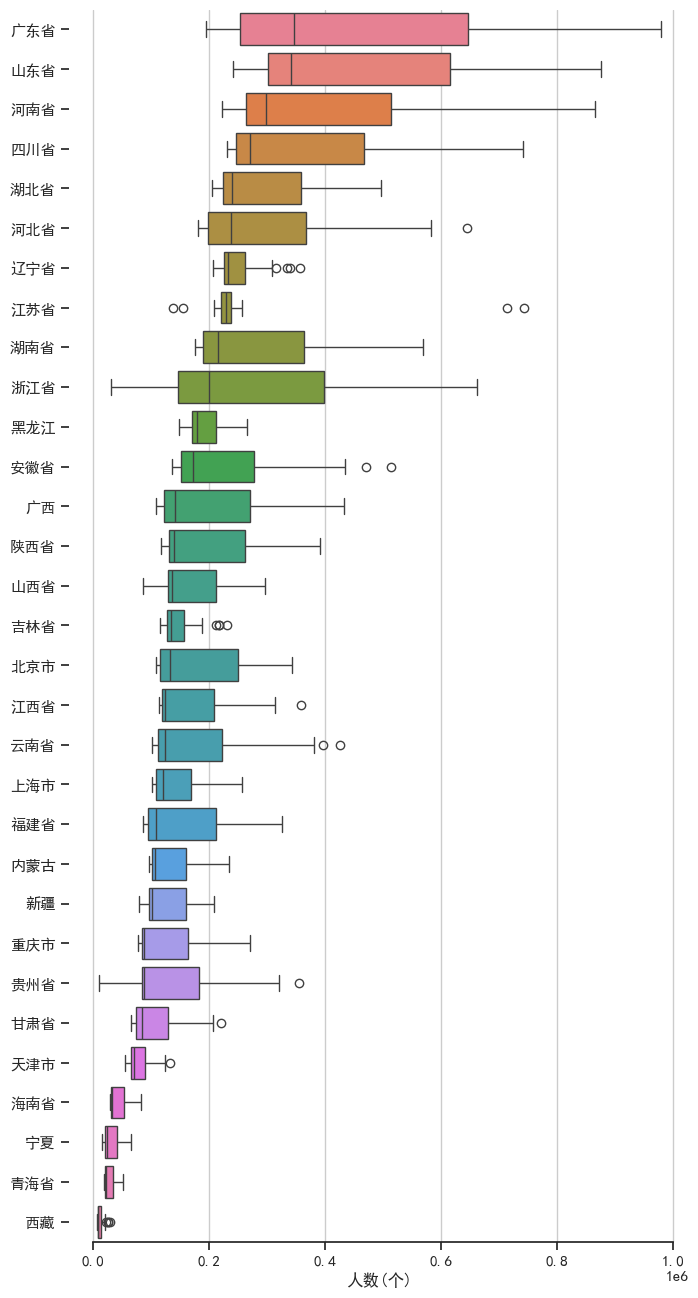

In [9]:
# 卫生技术人员数箱线图
plot_boxplot(personnels, '人数(个)')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10816\1006495843.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=xlabel, y="地区", data=growth_rate_df, palette="viridis")


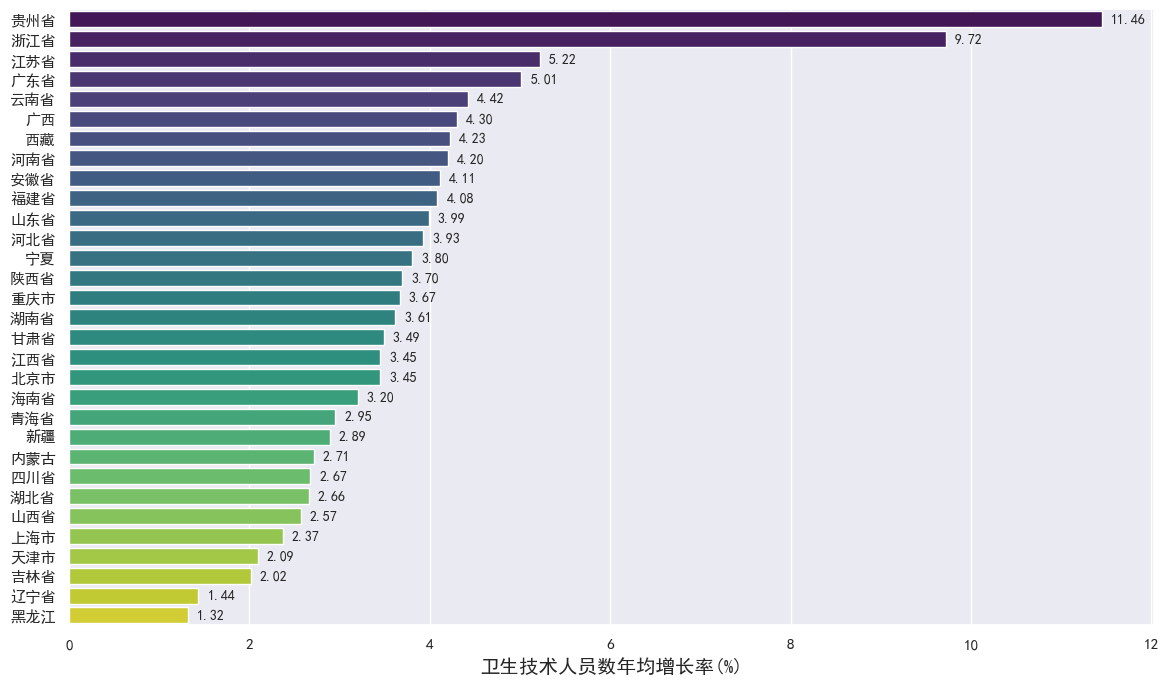

In [10]:
plot_bar_chart(personnels, "卫生技术人员数年均增长率(%)")

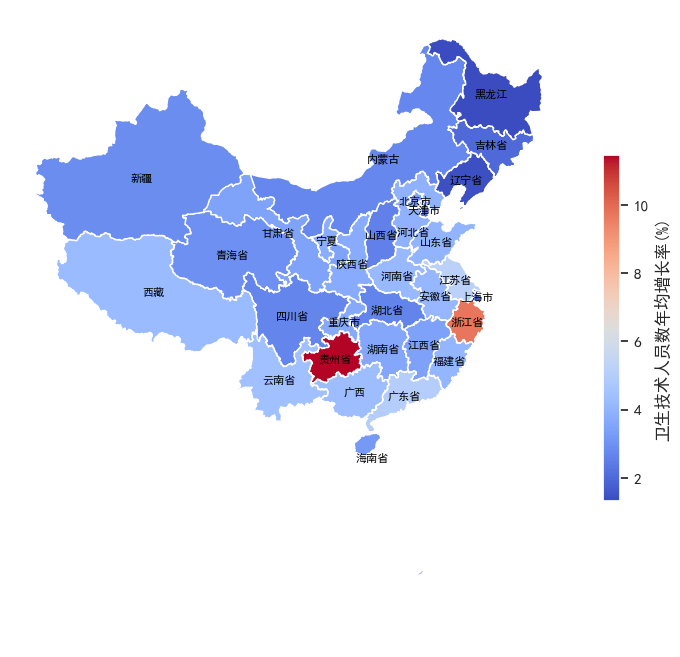

In [11]:
personnels_growth = calculate_regions_cagr(personnels)
personnels_growth_rate_df = pd.DataFrame(list(personnels_growth.items()), columns=["地区", "卫生技术人员数年均增长率(%)"])
plot_china_map(personnels_growth_rate_df, "卫生技术人员数年均增长率(%)")

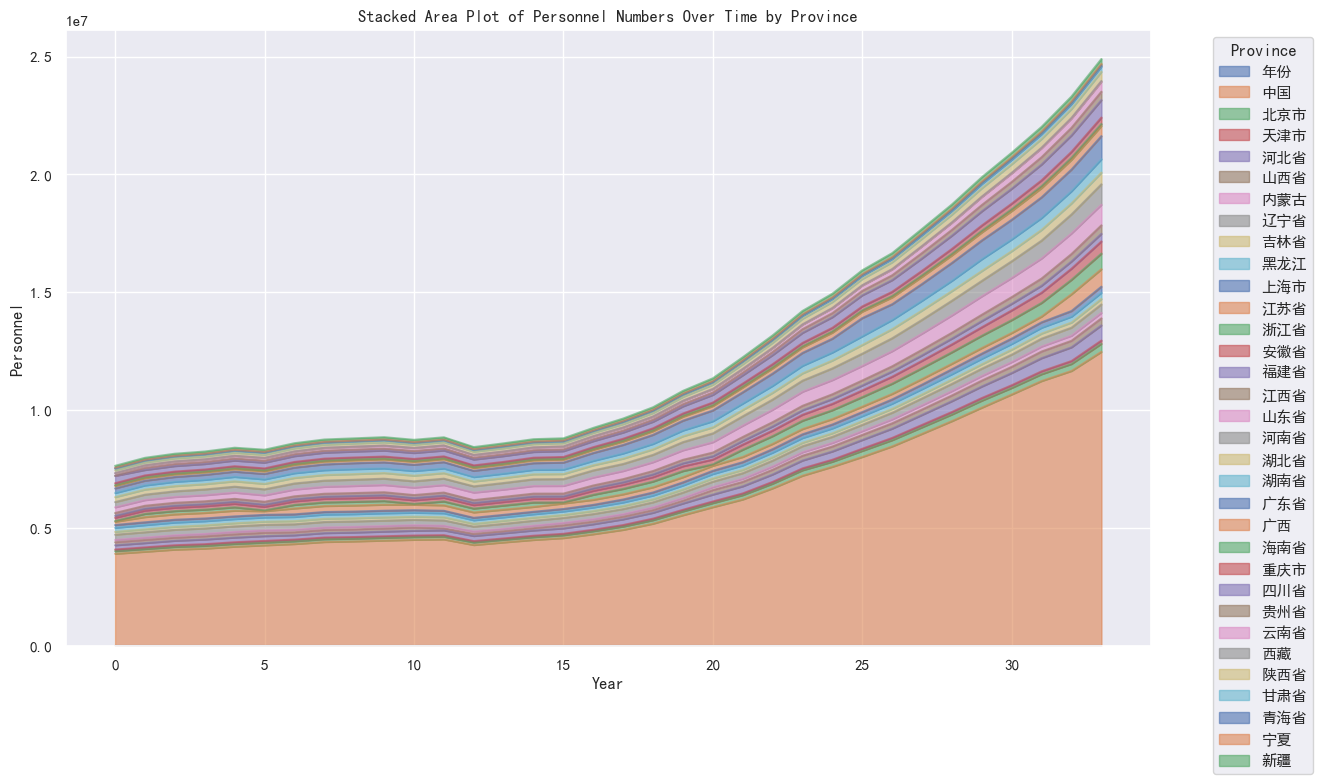

In [12]:
# 绘制区域图
personnels.plot.area(figsize=(14, 8), alpha=0.6)

# 调整图形
plt.title('Stacked Area Plot of Personnel Numbers Over Time by Province')
plt.xlabel('Year')
plt.ylabel('Personnel')
plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 执业（助理）医师人员数

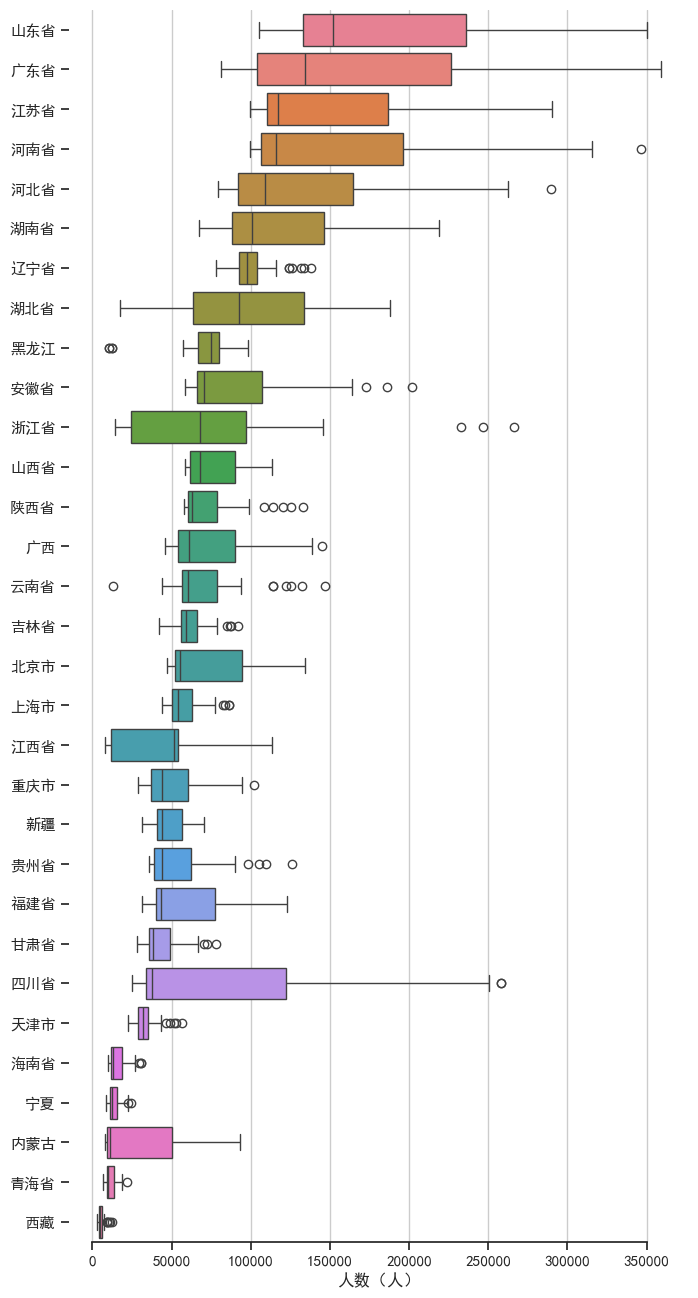

In [13]:
plot_boxplot(professors, "人数（人）")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10816\1006495843.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=xlabel, y="地区", data=growth_rate_df, palette="viridis")


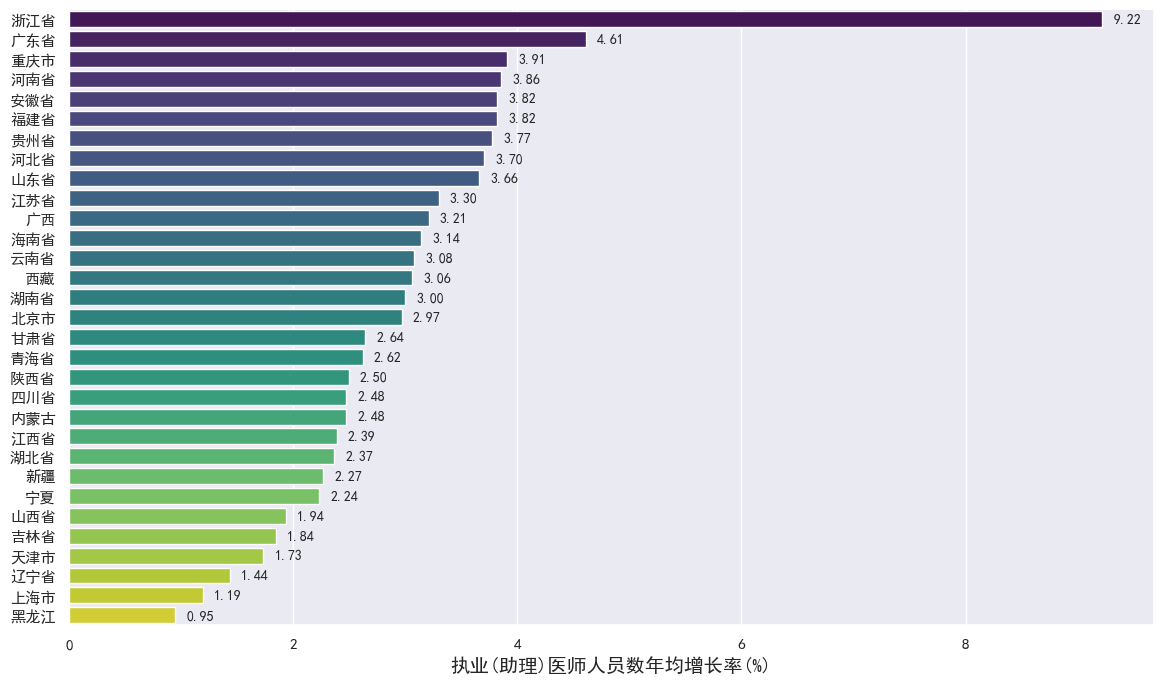

In [14]:
plot_bar_chart(professors, "执业(助理)医师人员数年均增长率(%)")

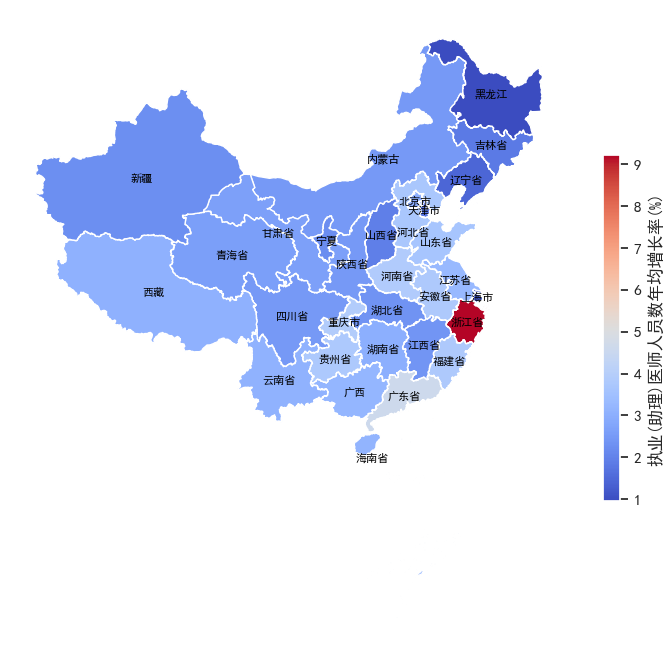

In [15]:
professors_growth = calculate_regions_cagr(professors)
professors_growth_rate_df = pd.DataFrame(list(professors_growth.items()), columns=["地区", "执业(助理)医师人员数年均增长率(%)"])
plot_china_map(professors_growth_rate_df, "执业(助理)医师人员数年均增长率(%)")

## 注册护士数(人)

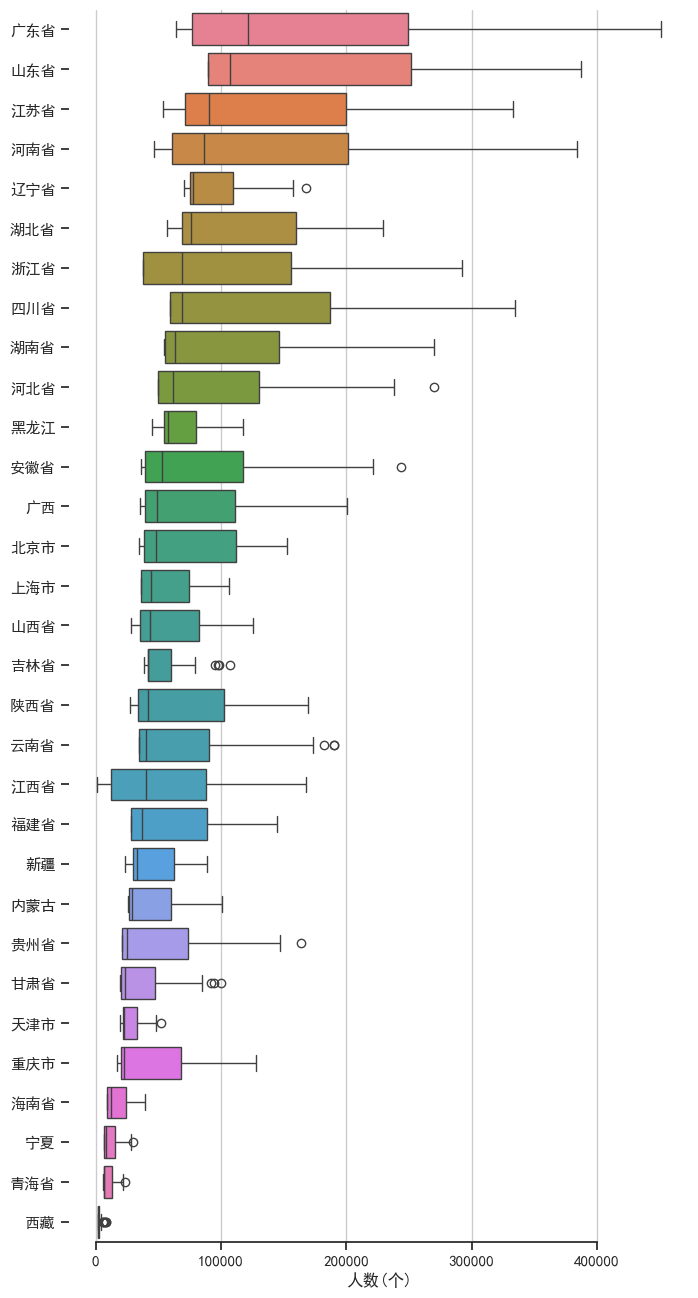

In [16]:
plot_boxplot(nurse, '人数(个)')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10816\1006495843.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=xlabel, y="地区", data=growth_rate_df, palette="viridis")


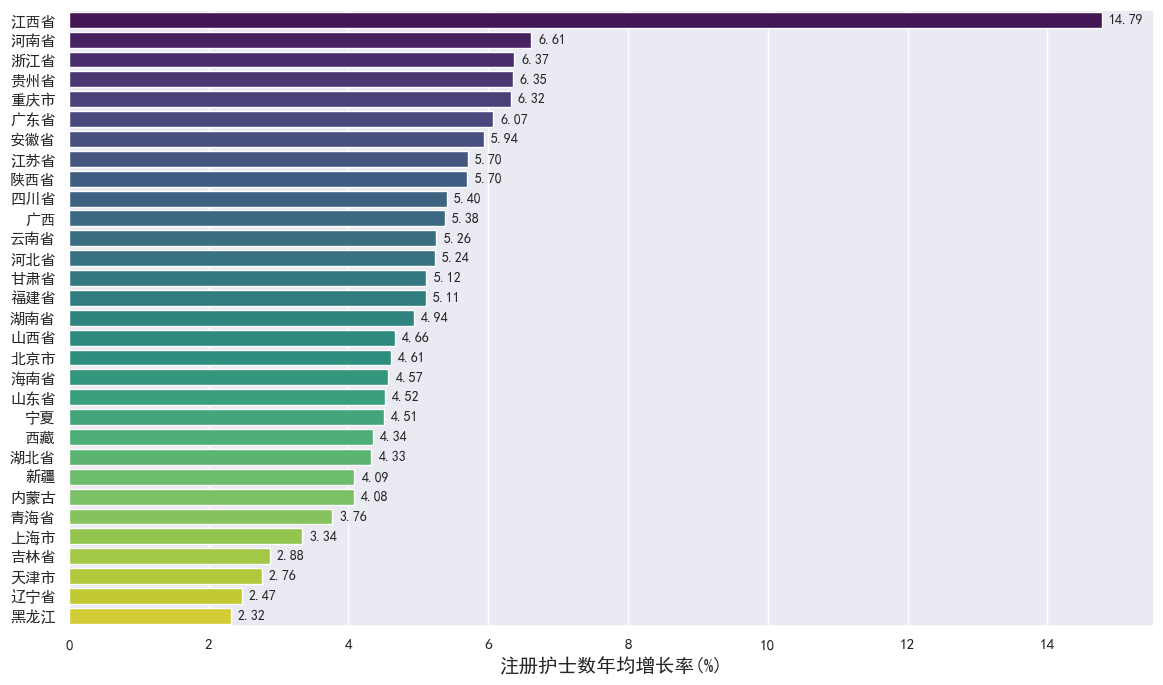

In [17]:
plot_bar_chart(nurse, "注册护士数年均增长率(%)")

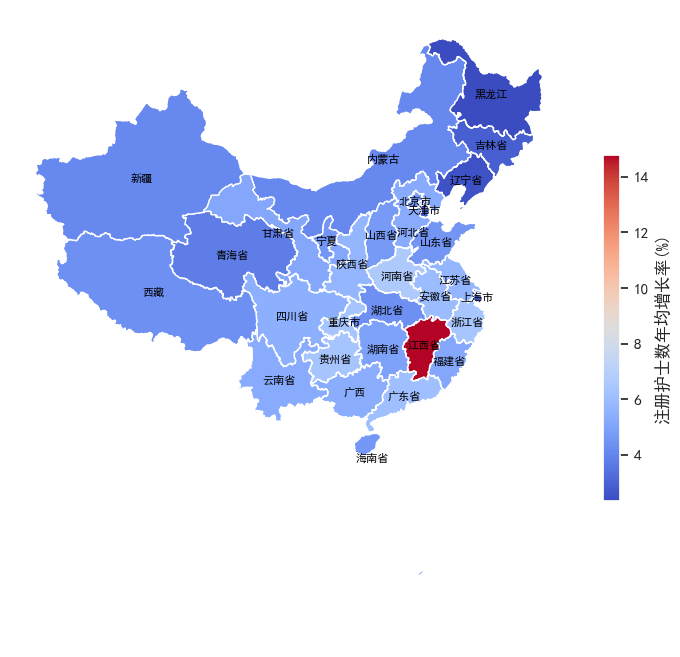

In [18]:
nurse_growth = calculate_regions_cagr(nurse)
nurse_growth_rate_df = pd.DataFrame(list(nurse_growth.items()), columns=["地区", "注册护士数年均增长率(%)"])
plot_china_map(nurse_growth_rate_df, "注册护士数年均增长率(%)")

## 卫生机构床位数

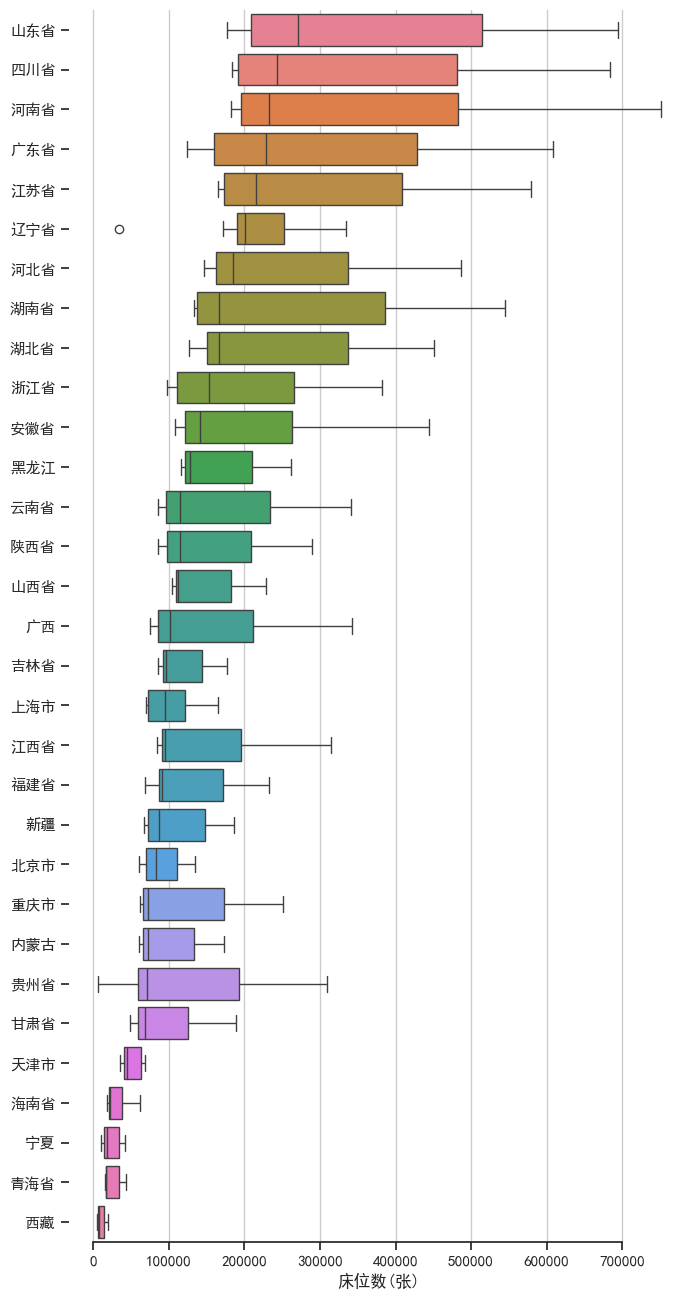

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10816\1006495843.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=xlabel, y="地区", data=growth_rate_df, palette="viridis")


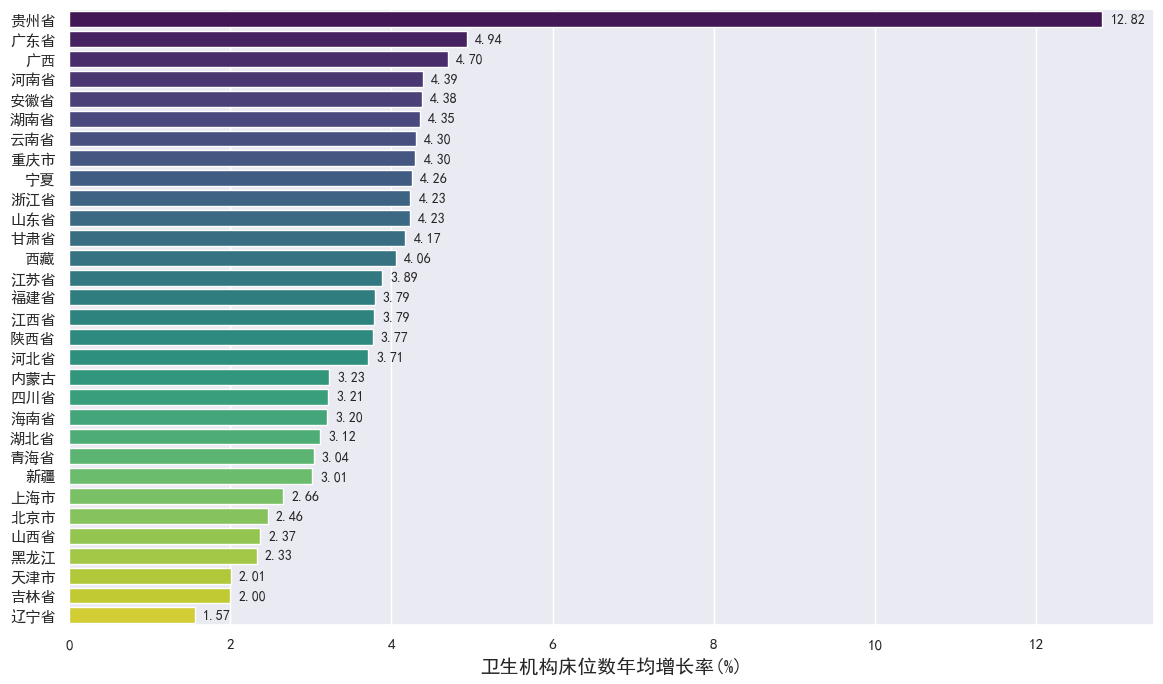

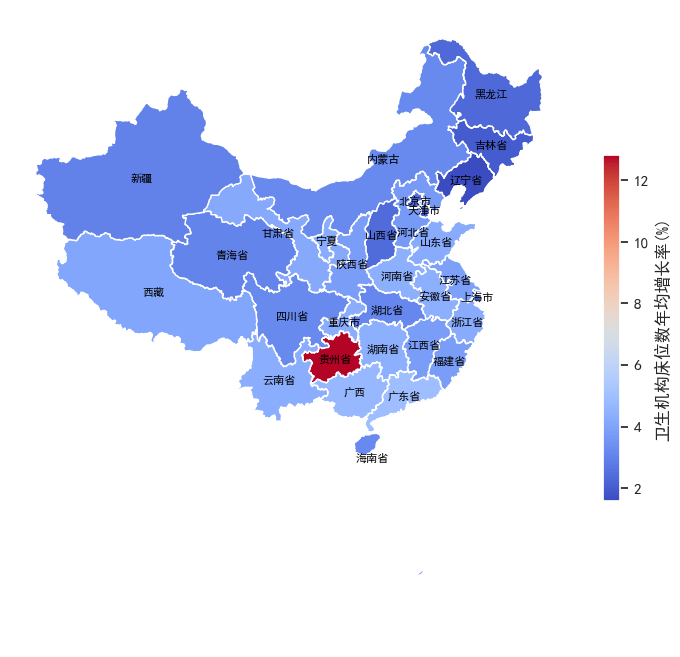

In [19]:
plot_boxplot(beds, '床位数(张)')
plot_bar_chart(beds, "卫生机构床位数年均增长率(%)")

beds_growth = calculate_regions_cagr(beds)
beds_growth_rate_df = pd.DataFrame(list(beds_growth.items()), columns=["地区", "卫生机构床位数年均增长率(%)"])
plot_china_map(beds_growth_rate_df, "卫生机构床位数年均增长率(%)")

## 医疗卫生机构数

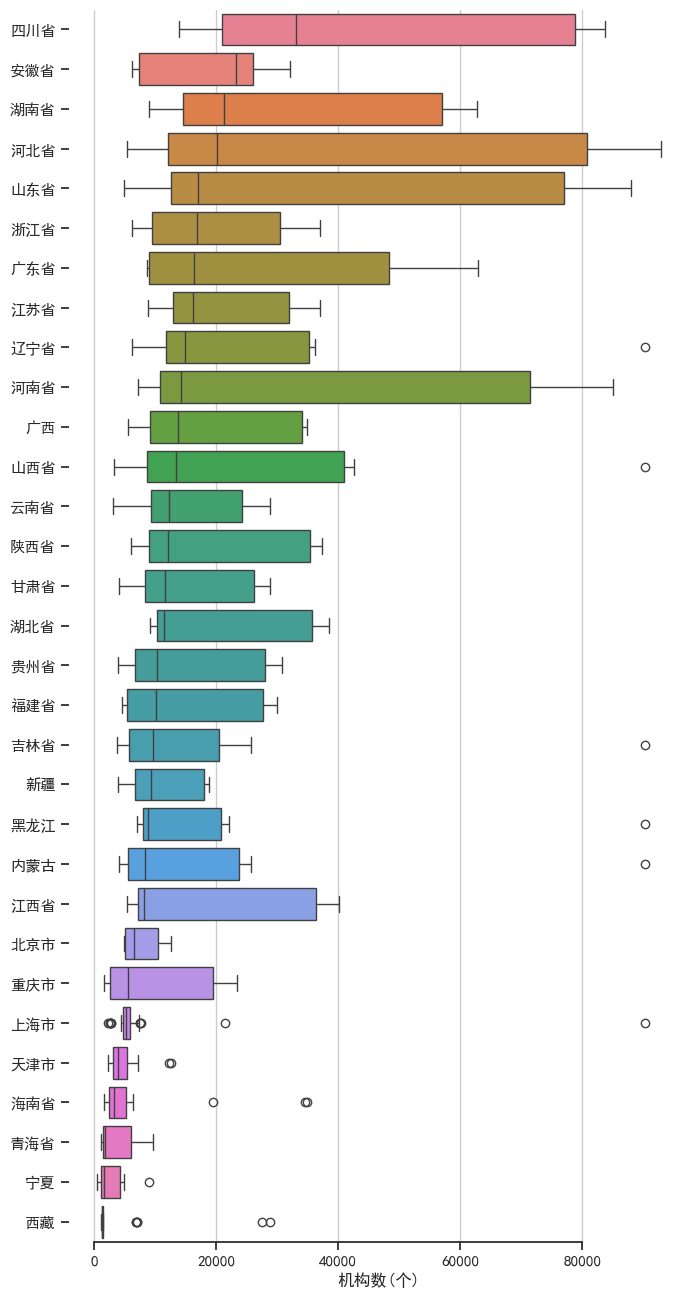

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10816\1006495843.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=xlabel, y="地区", data=growth_rate_df, palette="viridis")


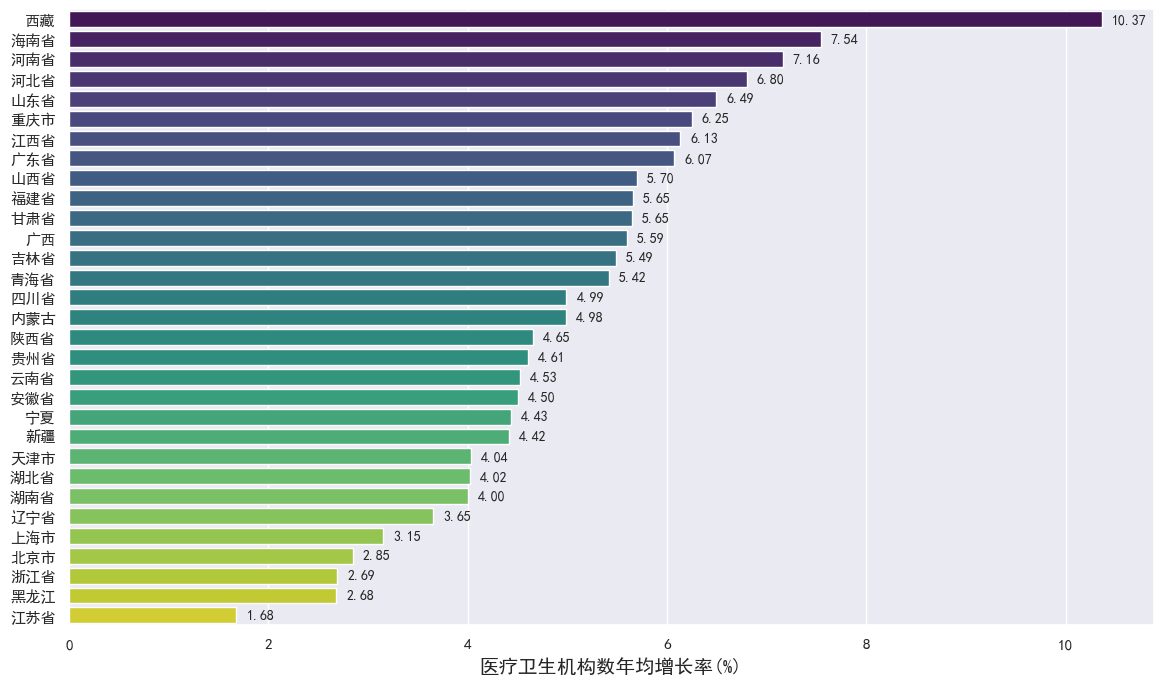

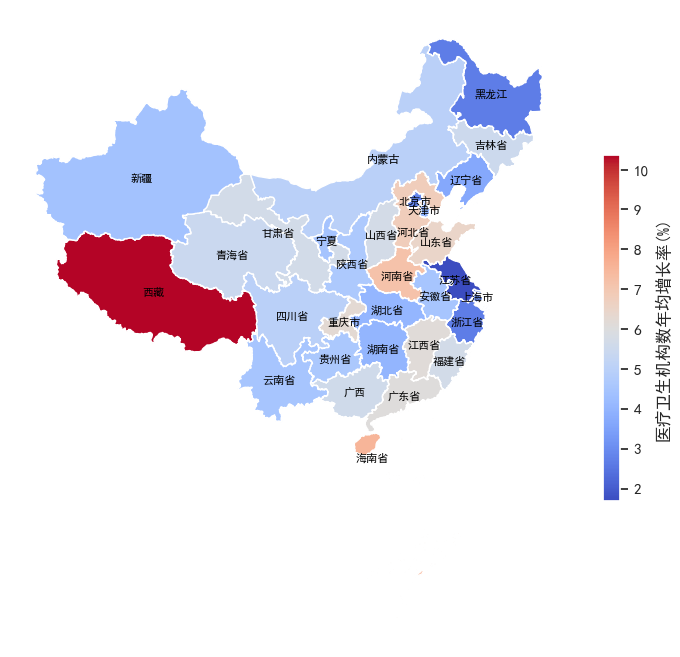

In [20]:
plot_boxplot(organizations, '机构数(个)')
plot_bar_chart(organizations, "医疗卫生机构数年均增长率(%)")

organizations_growth = calculate_regions_cagr(organizations)
organizations_growth_rate_df = pd.DataFrame(list(organizations_growth.items()), columns=["地区", "医疗卫生机构数年均增长率(%)"])
plot_china_map(organizations_growth_rate_df, "医疗卫生机构数年均增长率(%)")

## 财政支出中卫生经费(万元)

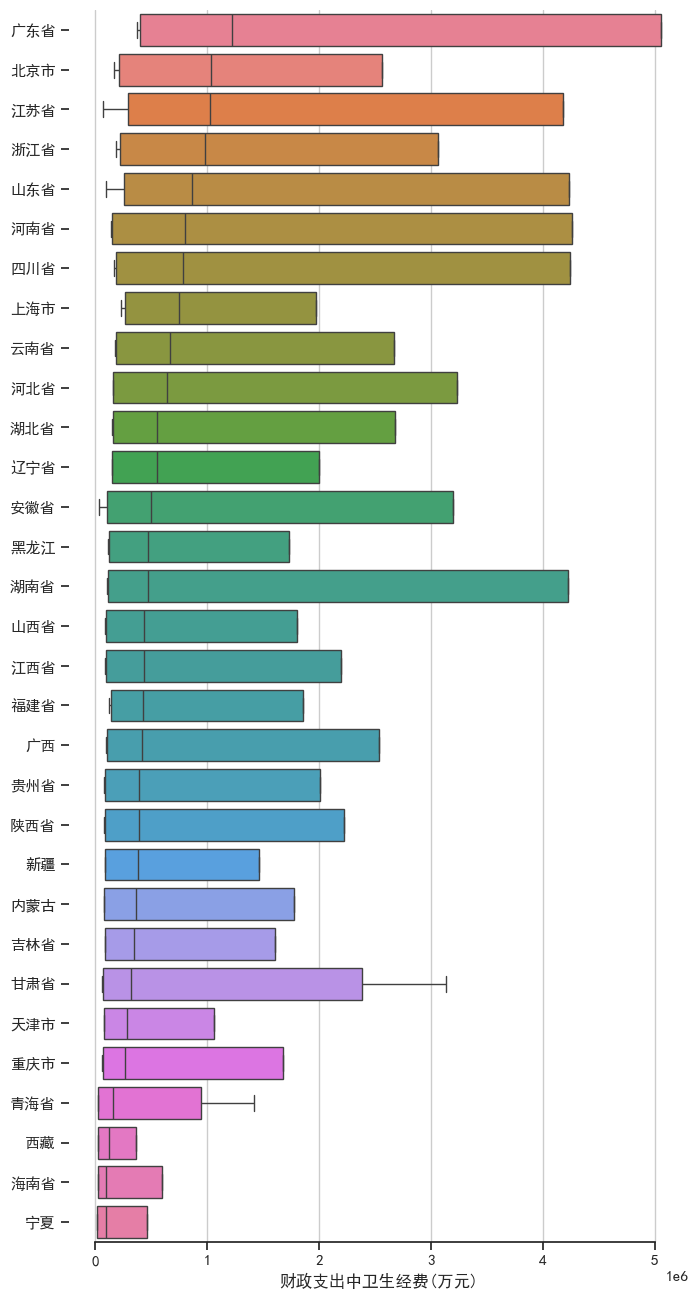

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10816\1006495843.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=xlabel, y="地区", data=growth_rate_df, palette="viridis")


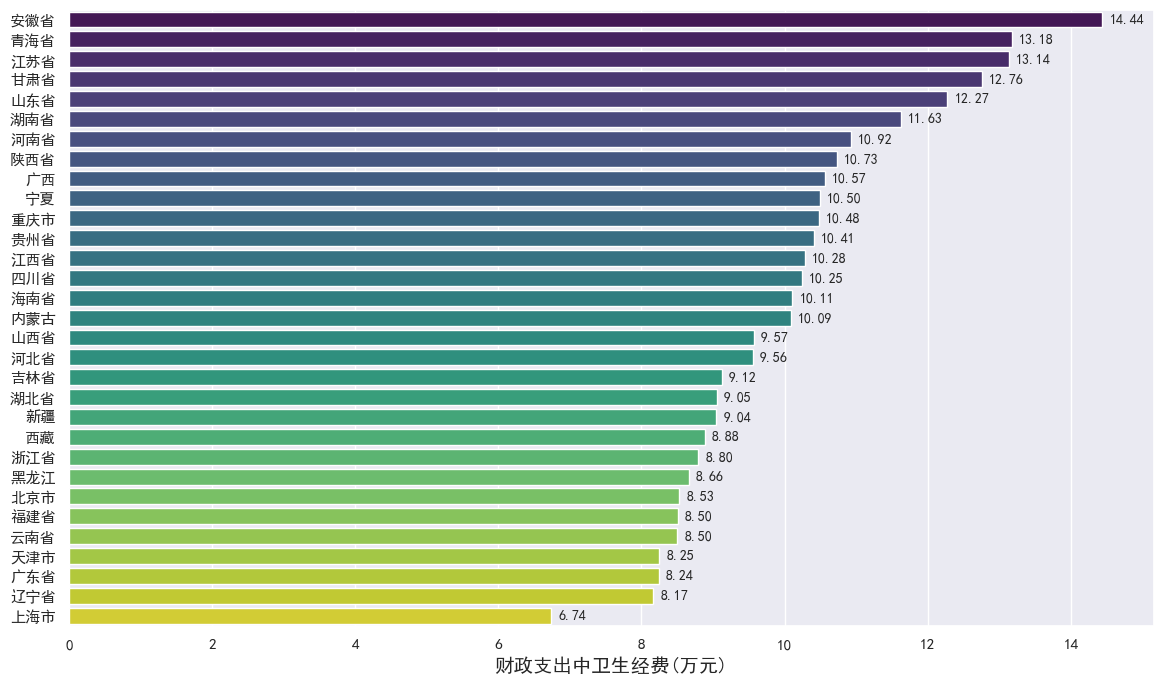

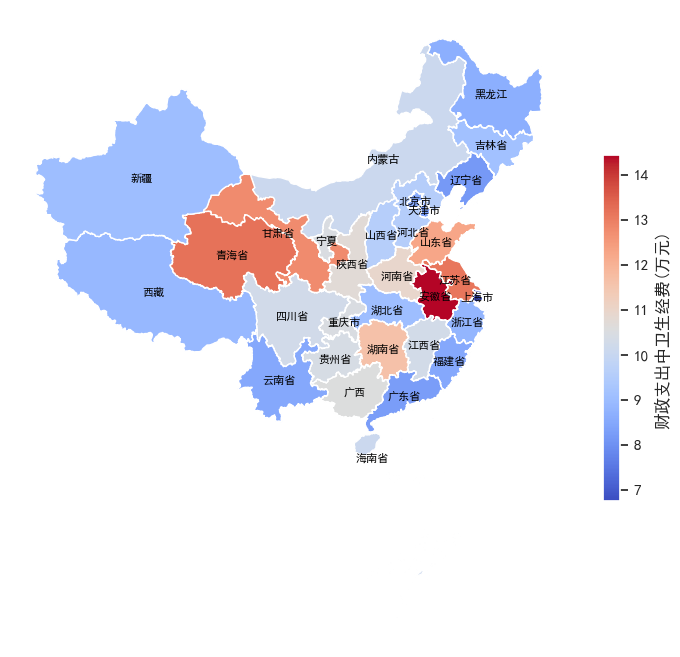

In [21]:
plot_boxplot(fee, '财政支出中卫生经费(万元)')
plot_bar_chart(fee, "财政支出中卫生经费(万元)")

fee_growth = calculate_regions_cagr(fee)
fee_growth_rate_df = pd.DataFrame(list(fee_growth.items()), columns=["地区", "财政支出中卫生经费(万元)"])
plot_china_map(fee_growth_rate_df, "财政支出中卫生经费(万元)")

## 综合评价

In [22]:
# 数据标准化
# 合并所有数据为一个字典
data_dict = {
    'personnels': personnels,
    'professors': professors,
    'nurse': nurse,
    'beds': beds,
    'organizations': organizations,
    'fee': fee
}

# 创建标准化的结果字典
standardized_data_dict = {}

# 对每个指标进行标准化
for key, df in data_dict.items():
    scaler = StandardScaler()
    df = df.drop(columns=['年份', '中国'])
    standardized_df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    standardized_data_dict[key] = standardized_df

In [23]:
# 综合得分计算
# 赋予权重
weights = {
    'personnels': 0.1,      # 卫生技术人员
    'professors': 0.1,      # 执业医师
    'nurse': 0.1,           # 注册护士
    'beds': 0.2,           # 卫生机构床位数
    'organizations': 0.3,  # 医疗卫生机构数
    'fee': 0.2              # 财政支出中卫生经费
}

# 计算综合得分
comprehensive_score = sum(weights[key] * standardized_data_dict[key] for key in weights)
mean_comprehensive_score = comprehensive_score.mean()

print("每年的综合得分:", comprehensive_score)
print("每年平均得分:", mean_comprehensive_score)

每年的综合得分:          北京市       天津市       河北省       山西省       内蒙古       辽宁省       吉林省  \
0  -1.063191 -0.731277 -0.931046 -0.918508 -0.712792 -0.780434 -0.816796   
1  -1.035531 -0.678429 -0.925770 -0.889094 -0.694678 -0.750414 -0.791346   
2  -1.026410 -0.670622 -0.908863 -0.896547 -0.664039 -0.714041 -0.768528   
3  -0.989788 -0.654883 -0.888559 -0.845626 -0.665202 -0.714933 -0.748313   
4  -0.980435 -0.649439 -0.889898 -0.821403 -0.651733 -0.702470 -0.739688   
5  -0.982026 -0.638489 -0.884373 -0.805670 -0.645404 -0.711220 -0.703583   
6  -0.805065 -0.514798 -0.960707 -0.915643 -0.642230 -0.713043 -0.721743   
7  -0.775730 -0.582859 -0.943777 -0.895524 -0.638357 -0.681335 -0.713362   
8  -0.873330 -0.667660 -0.777303 -0.813679 -0.581285 -0.610489 -0.650007   
9  -0.829265 -0.733772 -0.765166 -0.805306 -0.573571 -0.616640 -0.620810   
10 -0.785081 -0.735677 -0.775548 -0.700883 -0.561182 -0.613317 -0.696581   
11 -0.782619 -0.747436 -0.727002 -0.738289 -0.512495 -0.597511 -0.613530   
12 

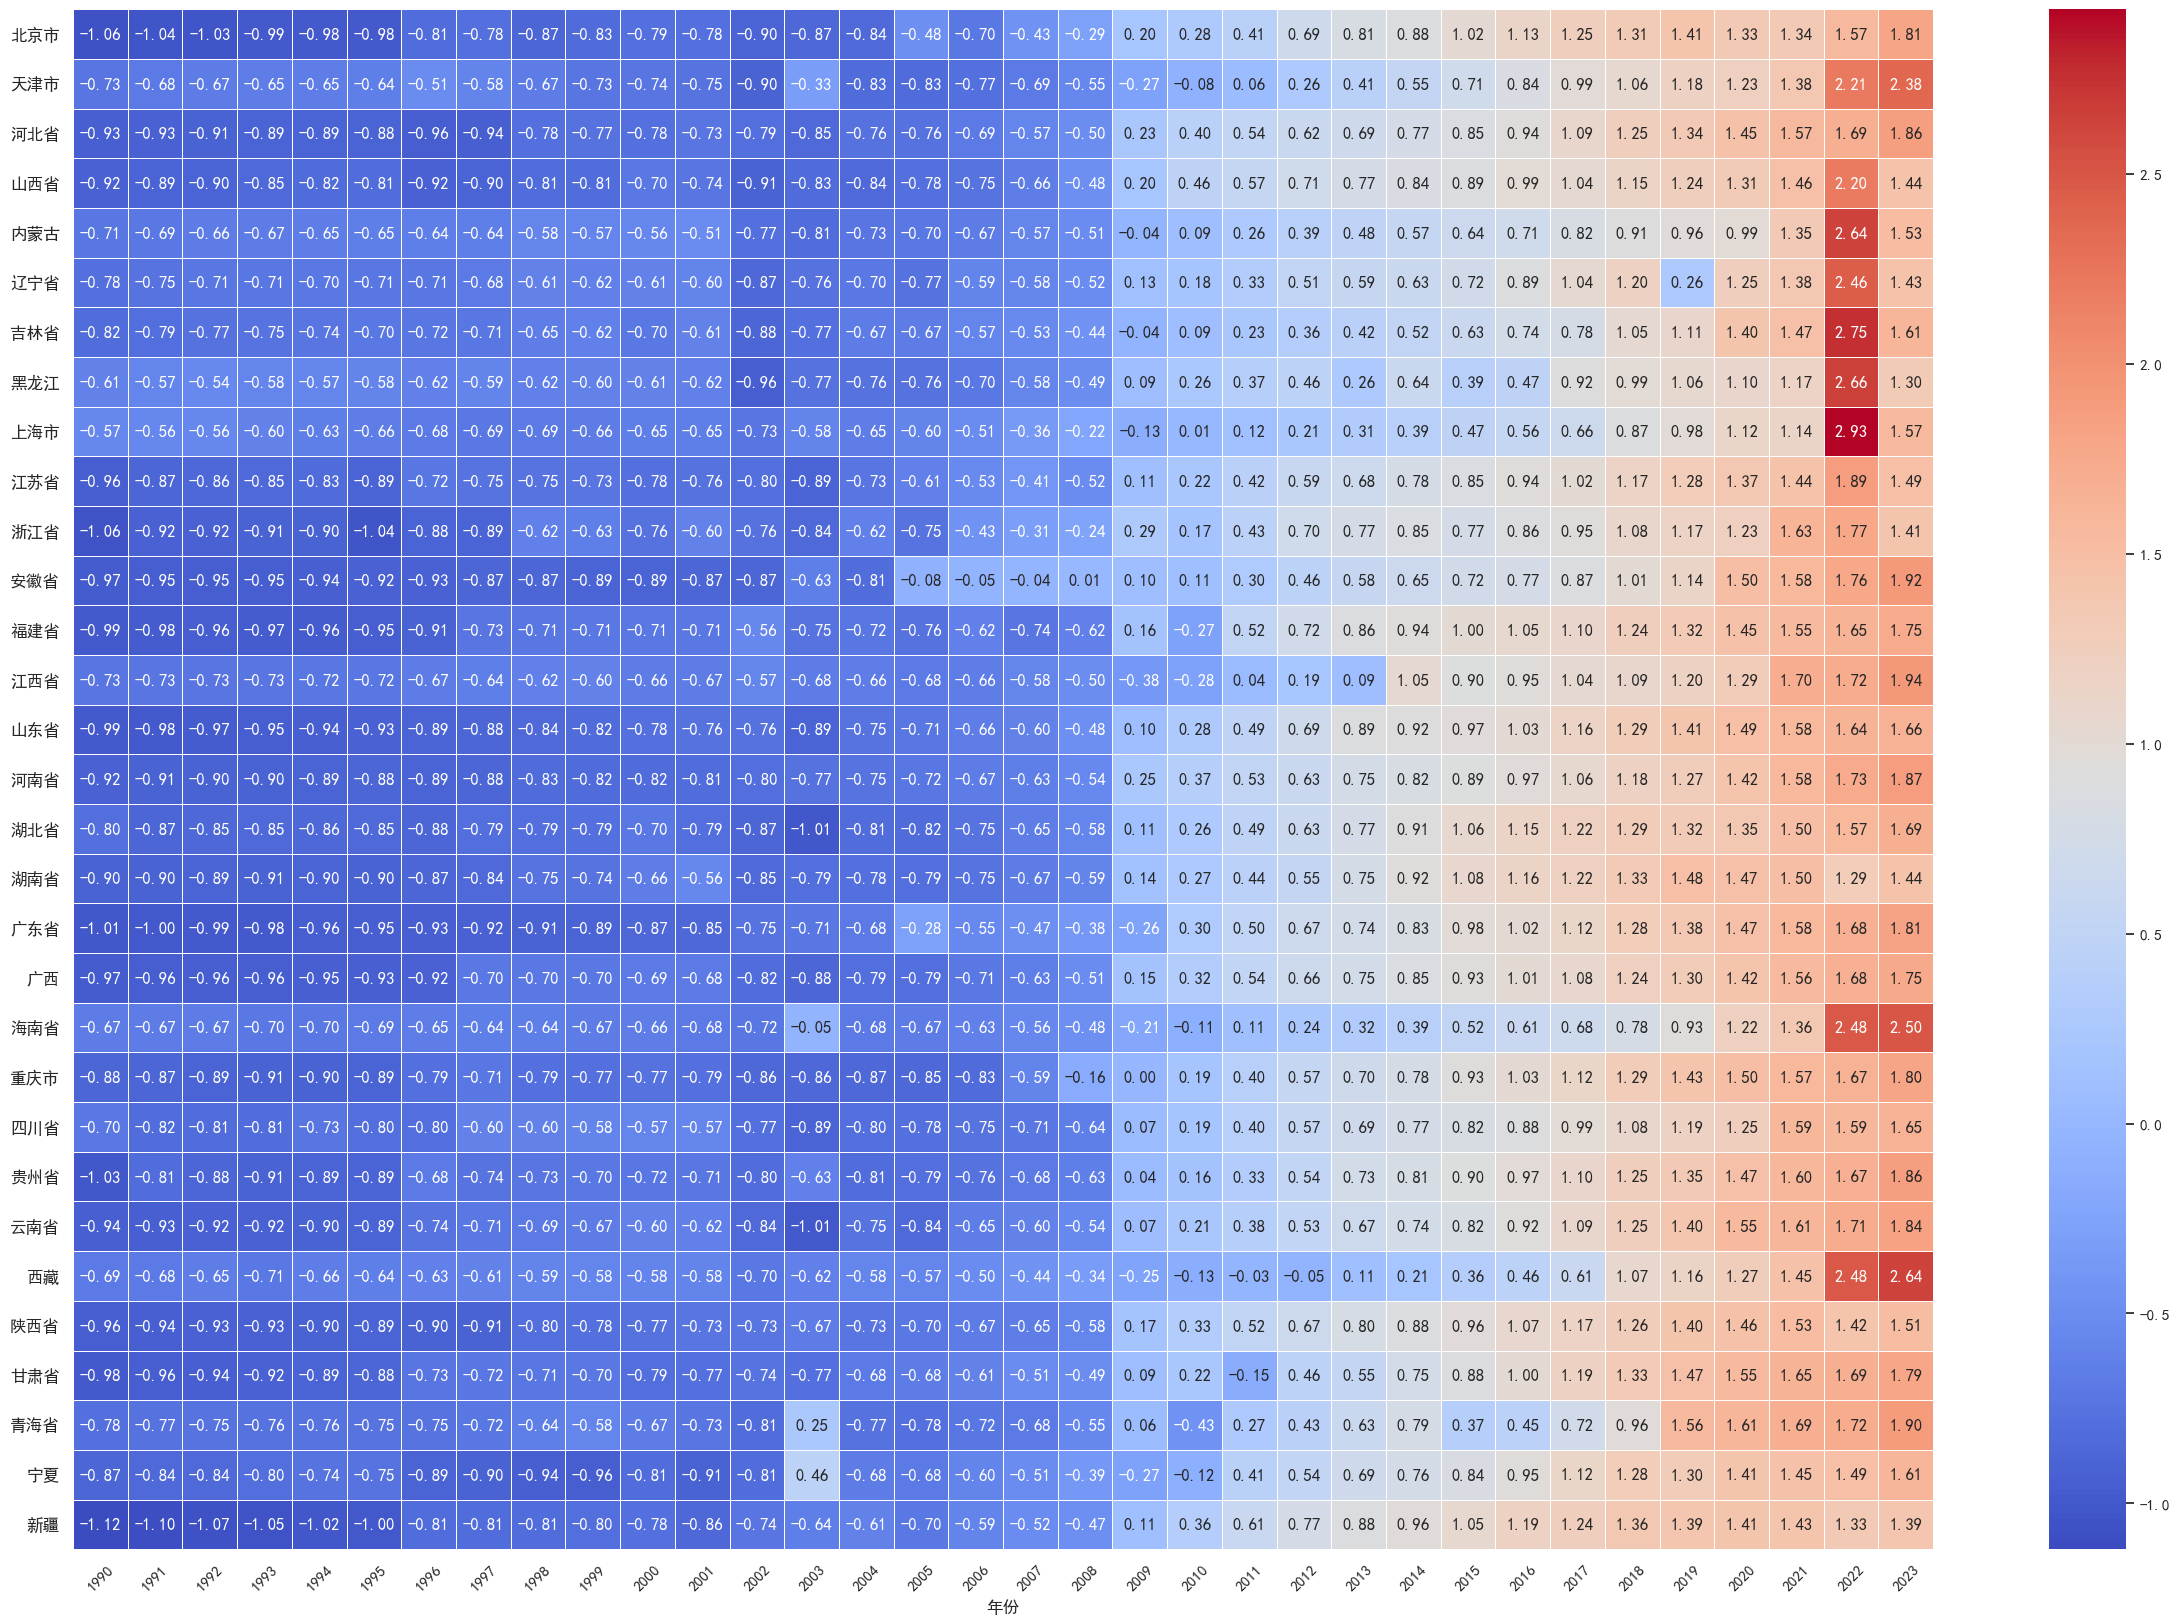

In [24]:
from matplotlib.font_manager import FontProperties
# 使用热力图展示每个地区每年的分数变化
comprehensive_score['年份'] = personnels['年份']
# 设置图表大小
plt.figure(figsize=(30, 20))

# 绘制热力图
sns.heatmap(comprehensive_score.set_index('年份').T, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=13)

font = FontProperties(weight='bold')
plt.setp(plt.gca().get_yticklabels(), fontproperties=font)

# 显示图表
plt.show()


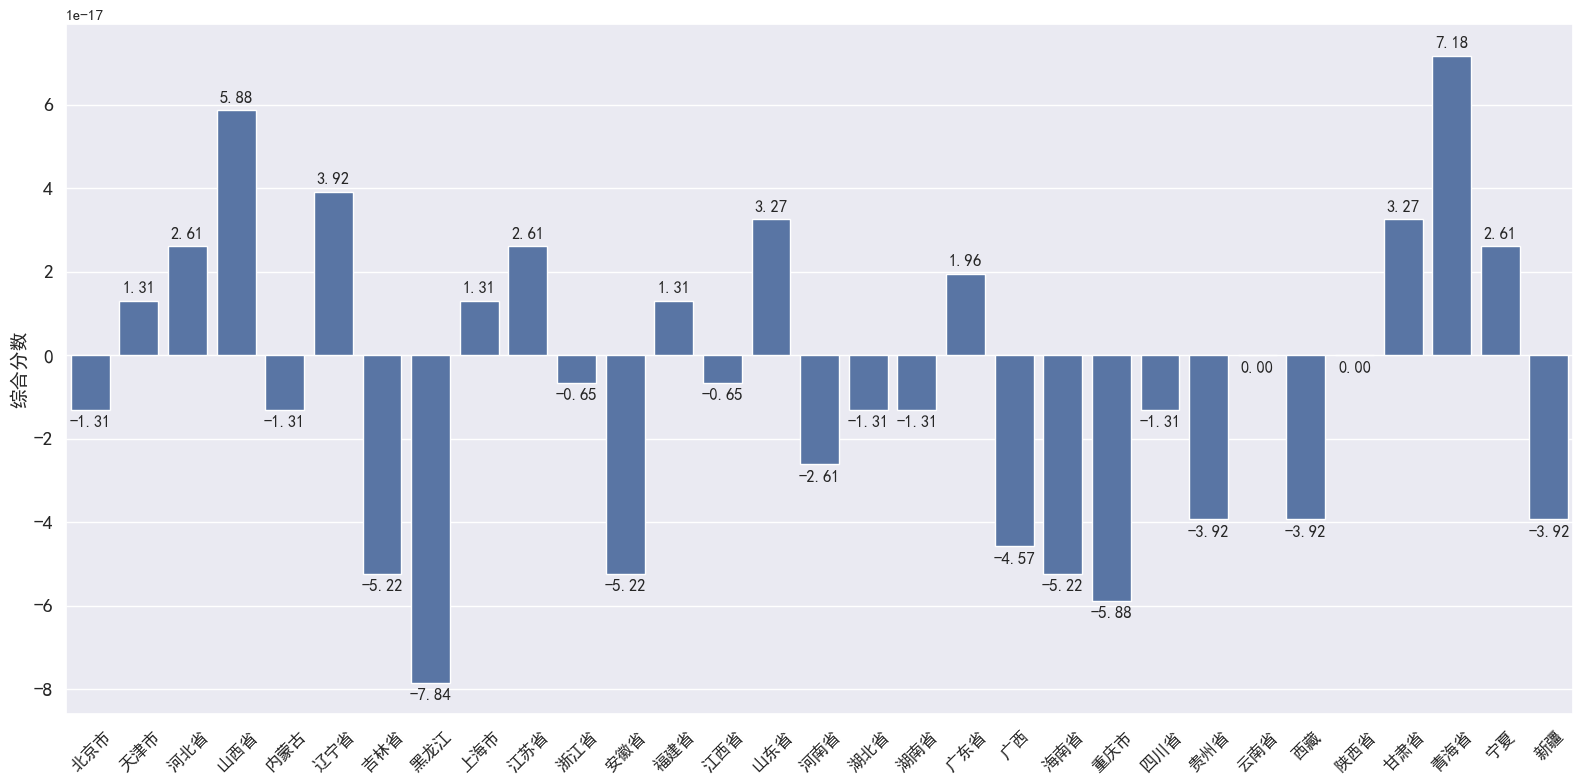

In [31]:
# 转成df并计算平均分
df_bar = mean_comprehensive_score.reset_index()
df_bar.rename(columns={0: 'Score'}, inplace=True)

# 设置图表大小
plt.figure(figsize=(16, 8))

# 绘制柱状图
ax = sns.barplot(x='index', y='Score', data=df_bar)

# 为每个柱体添加数值标记
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(format(height * 10**17, '.2f'),
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 9),  # 正值的数值标记放在柱体上方
                    textcoords='offset points',
                    fontsize=12)
    else:
        ax.annotate(format(height * 10**17, '.2f'),
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, -9),  # 负值的数值标记放在柱体下方
                    textcoords='offset points',
                    fontsize=12)

# 设置标题和轴标签
plt.xlabel('')
plt.ylabel('综合分数', fontsize=14)

# 旋转 x 轴标签以避免重叠
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=14)

# 显示图表
plt.tight_layout()
plt.show()